In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

Importieren relevanter Bibliotheken

In [2]:
data = pd.read_csv('../data/train.csv')

data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

Datensatz lesen. Konvertieren des Datensatzes in ein zweidimensionales Numpy-Array. Dann mischen wir die Daten, um die Zufälligkeit für das Training zu gewährleisten

In [3]:
data_dev = data[0:1000].T # Daten aufteilen
Y_dev = data_dev[0] # Labels extrahieren
X_dev = data_dev[1:n] # Features extrahieren
X_dev = X_dev / 255. # Normalisierung

data_train = data[1000:m].T # Daten aufteilen
Y_train = data_train[0] # Labels extrahieren
X_train = data_train[1:n] # Features extrahieren
X_train = X_train / 255. # Normalisierung
_,m_train = X_train.shape # Größe des Trainingsdatensatzes bestimmen

Hier teilen wir das Dataset in ein Entwicklungssatz und ein Trainingssatz auf. Die Daten werden auch transponiert, um der erwarteten Eingabeform des neuronalen Netzwerks zu entsprechen. (Features als Spalten und Beispiele als Zeilen) Schließlich werden die Pixelwerte durch Teilen durch 255 normalisiert, sodass sie zwischen 0 und 1 liegen. Diese Normalisierung ist für die Stabilität des Trainings und eine schnellere Konvergenz unerlässlich.

In [4]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5 # Für die erste versteckte Schicht
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5  # Für die zweite versteckte Schicht
    b2 = np.random.rand(10, 1) - 0.5
    W3 = np.random.rand(10, 10) - 0.5  # Für die Ausgabeschicht
    b3 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2, W3, b3

Unser Netzwerk besteht also aus vier Schichten. Die Eingabeschicht, zwei versteckte Schichten, und die Ausgabeschicht. Wir initialisieren die Werte mithilfe von np.random.rand() als Werte zwischen 0 und 1. Indem wir den Bereich auf [-0.5, 0.5] verschieben, erreichen wir eine schneller Konvergenz. (Da zu große Werte dazu führen können, dass der Gradient "explodiert" und somit das Training instabil wird, zu kleine Werte dazu, dass der Gradient "verschwindend" klein wird und somit das Training sehr langsam wird)


W1: 10 Neuronen in der ersten versteckten Schicht, jedes mit 784 Eingangsmerkmalen/Gewichten (eben die 28x28 Pixel)
b1: Bias-Werte für die 10 Neuronen der ersten Schicht

W2, b2 und W3, b3 ähnlich, ebenfalls 10 Neuronen pro Schicht


Die Initiliasierung der Gewichte und Verzerrungen kann einen großen Einfluss darauf haben, wie gut und wie schnell ein neuronales Netzwerk während des Trainings konvergiert. Es gibt viele fortschrittliche Methoden zur Initialisierung, aber der hier gezeigte Ansatz mit kleinen zufälligen Werten ist ein einfacher und oft verwendeter Ansatz, insbesondere für kleinere Netzwerke oder zum Einstieg.

In [5]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

Die beiden Aktivierungsfunktionen, die unser Neuronales Netzwerk benutzt:

- ReLU: Benutzen wir für die zwei versteckten Schichten. Alle Werte, die kleiner als 0 sind, werden zu 0, und alle Werte, die größer als 0 sind, bleiben unverändert.

- Softmax: Benutzen wir in der Ausgabeschicht. Sie fungiert als Wahrscheinlichkeitsverteilung, die Werte liegen also zwischen 0 und 1 und die Summe aller Werte ist genau 1. Mit ihrer Hilfe entscheidet sich das Netzwerk in der Ausgabeschicht für eines der 10 Neuronen (Maximum).

In [6]:
def forward_prop(W1, b1, W2, b2, W3, b3, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)  # ReLU für die zweite versteckte Schicht
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

Diese Funktion führt die Vorwärtspropagation des Netzwerks durch.

Sie berechnet anhand der aktuellen Gewichte und Verzerrungen aller Schichten des Netzwerks die entsprechenden Ausgaben bzw. Aktivierungen für X. Z1 entspricht also dem Produkt aus den Gewichten W1 und der Eingabe X mit anschließender Hinzufügung der Verzerrung b1. Außerdem bestimmen wir dann die Aktivierung A1 der ersten Schicht für X anhand der gewichteten Summe Z1.

Das gleiche passiert für die zweite Schicht.

Die dritte Schicht unterscheidet sich bloß in der Aktivierungsfunktion, wie bereits erklärt.

Als Rückgabe erhalten wir also die gewichteten Summen und Aktivierungen aller Schichten für die Eingabe X.

In [7]:
# wenn Input (Z) kleiner gleich 0 => false, sonst true
def ReLU_deriv(Z):
    return Z > 0

# 1-aus-n-Code, stellt Dezimalzahlen als Binärzahlen da
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y



def backward_prop(Z1, A1, Z2, A2, A3, W2, W3, X, Y, m):
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y # Fehler zwischen Vorhersagen und tatsächlichen Labels
    dW3 = 1 / m * dZ3.dot(A2.T) # Verlustgradient bezüglich W3
    db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True) # Verlustgradient bezüglich b3
    
    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(Z2) # Fehlersignal der zweiten versteckten Schicht (multipliziert mit 0 oder 1, abhängig von ReLU)
    dW2 = 1 / m * dZ2.dot(A1.T) # Verlustgradient bezüglich W2
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True) # Verlustgradient bezüglich b2
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1) # Fehlersignal der ersten versteckten Schicht (multipliziert mit 0 oder 1, abhängig von ReLU)
    dW1 = 1 / m * dZ1.dot(X.T) # Verlustgradient bezüglich W1
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True) # Verlustgradient bezüglich b1
    
    return dW1, db1, dW2, db2, dW3, db3


Das Ziel der Rückwertpropagation ist es, zu verstehen, wie sich eine Änderung der Gewichte und Verzerrungen auf den Gesamtfehler des Netzwerks auswirkt.

Rückwärtspropagation ist der Prozess, bei dem die Verlustgradienten in Bezug auf die Gewichte und Verzerrungen berechnet werden. Diese Gradienten geben die Richtung an, in welcher die Funktion, also die Fehlerquote, am steilsten ansteigt.

Das Fehlersignal ist im Wesentlichen eine Maßeinheit dafür, wie "falsch" die Ausgaben eines Neurons bzw. der Schicht sind, und es liefert die notwendige Information, um die Gewichte und Verzerrungen während des Trainings anzupassen.

In [8]:
def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    W3 -= alpha * dW3
    b3 -= alpha * db3
    return W1, b1, W2, b2, W3, b3

Diese Funktion aktualisiert die Gewichte und Verzerrungen des Netzwerks in Richtung des negativen Gradienten. Dieser iterative Prozess hilft dem Netzwerk, aus seinen Fehlern zu lernen. 'alpha' ist die Lernrate, die die Schrittgröße jeder Aktualisierung bestimmt.

In [11]:
def get_predictions(A3):
    return np.argmax(A3, 0)


def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size


def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, A3, W2, W3, X, Y, m_train)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A3)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2, W3, b3

Diese Funktion führt das Training unseres neuronalen Netzwerks durch. Es verwendet den Gradientenabstieg, um die Gewichte und Verzerrungen kontinuierlich zu aktualisieren. Am Ende des Trainings sollte unser Netzwerk besser auf die Daten abgestimmt sein und genauere Vorhersagen treffen können.

Die Analogie mit einer Kugel, die einen Hang hinunterrollt:

- Die Kugel repräsentiert unsere aktuelle Position (oder den aktuellen Wert der Gewichte) im Fehlerlandschaft.
    
- Der Hang repräsentiert die Verlustfunktion.
    
- Die Schwerkraft zwingt die Kugel dazu, den Weg des geringsten Widerstands zu suchen und sich bergab zu bewegen.


- Eine hohe Lernrate (α) würde bedeuten, dass die Kugel einen großen Sprung bergab macht. Dies könnte zwar schneller zum Tal (dem Minimum) führen, birgt aber auch das Risiko, dass die Kugel das Tal überquert und auf der anderen Seite wieder nach oben rollt. In anderen Worten, eine zu hohe Lernrate kann dazu führen, dass der Algorithmus "überschwingt" und nicht konvergiert.
    
- Eine niedrige Lernrate würde bedeuten, dass die Kugel kleinere Schritte bergab macht. Dies kann dazu führen, dass die Kugel sicherer und stetiger zum Tal gelangt, aber es könnte sehr lange dauern. Eine zu niedrige Lernrate kann den Trainingsprozess erheblich verlangsamen.

In [20]:
W1, b1, W2, b2, W3, b3 = gradient_descent(X_train, Y_train, 0.10, 400)

Iteration:  0
[7 7 7 ... 7 6 6] [8 4 3 ... 4 1 0]
0.08604878048780487
Iteration:  10
[7 7 7 ... 7 7 7] [8 4 3 ... 4 1 0]
0.1648048780487805
Iteration:  20
[7 7 7 ... 1 1 7] [8 4 3 ... 4 1 0]
0.23341463414634148
Iteration:  30
[7 7 7 ... 1 1 7] [8 4 3 ... 4 1 0]
0.26678048780487806
Iteration:  40
[7 7 4 ... 1 1 7] [8 4 3 ... 4 1 0]
0.2937560975609756
Iteration:  50
[7 7 4 ... 1 1 0] [8 4 3 ... 4 1 0]
0.32963414634146343
Iteration:  60
[7 7 9 ... 1 1 0] [8 4 3 ... 4 1 0]
0.37585365853658537
Iteration:  70
[7 4 9 ... 8 1 0] [8 4 3 ... 4 1 0]
0.4230731707317073
Iteration:  80
[7 4 9 ... 8 1 0] [8 4 3 ... 4 1 0]
0.4670975609756098
Iteration:  90
[7 4 9 ... 8 1 0] [8 4 3 ... 4 1 0]
0.5020975609756098
Iteration:  100
[2 4 9 ... 8 1 0] [8 4 3 ... 4 1 0]
0.5305609756097561
Iteration:  110
[3 4 3 ... 4 1 0] [8 4 3 ... 4 1 0]
0.555
Iteration:  120
[3 4 3 ... 4 1 0] [8 4 3 ... 4 1 0]
0.5762439024390243
Iteration:  130
[3 4 3 ... 4 1 0] [8 4 3 ... 4 1 0]
0.5950487804878049
Iteration:  140
[3 4 3 ..

In [21]:
def make_predictions(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions(A3)
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2, W3, b3)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  8


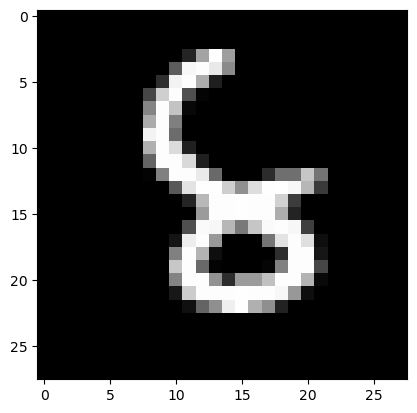

Prediction:  [4]
Label:  4


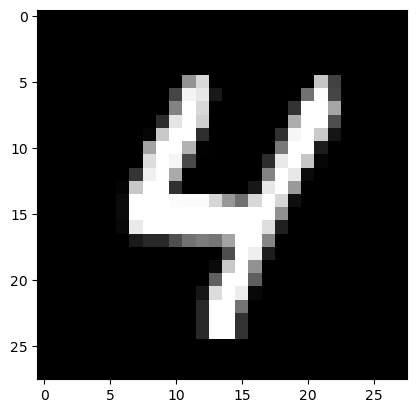

Prediction:  [3]
Label:  3


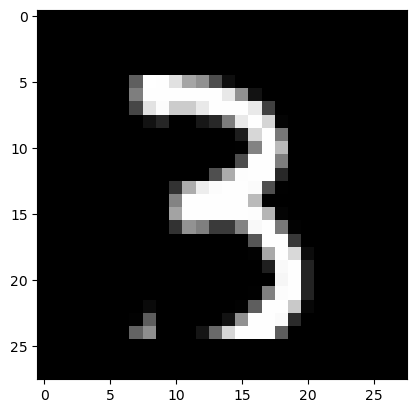

Prediction:  [3]
Label:  3


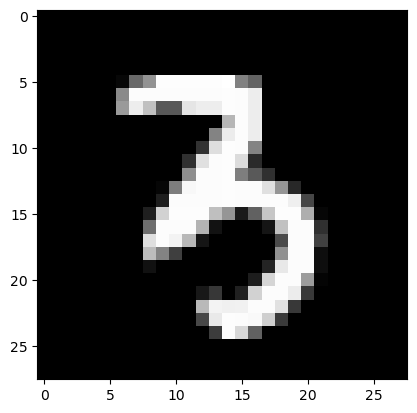

In [22]:
test_prediction(0, W1, b1, W2, b2, W3, b3)
test_prediction(1, W1, b1, W2, b2, W3, b3)
test_prediction(2, W1, b1, W2, b2, W3, b3)
test_prediction(3, W1, b1, W2, b2, W3, b3)

In [23]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2, W3, b3)
get_accuracy(dev_predictions, Y_dev)

[4 8 1 6 6 5 0 3 1 9 7 0 8 0 3 6 6 3 0 3 7 3 0 0 6 9 8 4 8 5 5 7 7 0 4 8 8
 3 8 8 3 0 3 1 3 3 1 7 4 0 7 6 6 8 3 3 1 9 3 4 2 7 0 3 8 1 9 0 0 2 2 0 6 7
 1 7 4 7 7 9 9 2 5 1 1 4 6 4 6 3 9 8 7 1 3 2 9 2 5 4 2 1 2 4 6 7 3 0 1 7 1
 6 2 6 9 0 3 6 1 1 0 0 8 3 6 3 6 9 3 7 8 8 0 5 2 6 7 8 3 3 2 0 9 8 8 8 2 4
 7 4 7 8 2 3 7 1 4 6 9 4 7 9 1 1 3 1 4 9 9 9 2 6 6 8 4 1 4 9 3 3 8 9 7 9 7
 8 0 4 3 6 8 8 8 9 4 7 5 6 4 5 6 2 9 3 0 8 6 3 2 2 4 7 6 9 1 8 6 5 2 3 8 7
 6 4 6 4 8 2 9 1 5 7 6 2 0 7 6 8 0 2 1 9 8 7 8 9 5 6 8 6 0 2 5 0 1 4 2 7 9
 9 6 1 7 2 9 1 3 8 6 9 6 6 1 8 9 3 9 1 9 4 6 7 7 0 9 9 9 8 0 8 5 2 3 4 7 1
 9 4 1 7 7 7 6 1 5 8 2 1 4 1 2 7 8 7 1 9 6 0 8 5 4 1 6 3 3 9 9 8 8 2 3 7 0
 9 5 5 0 2 1 3 2 6 3 8 8 7 0 8 0 4 1 1 4 8 7 2 1 3 4 0 4 0 2 7 1 7 6 1 2 9
 3 7 8 5 8 9 0 8 9 8 9 1 5 4 1 6 8 0 2 5 5 9 0 8 6 3 8 1 2 2 0 4 6 8 6 1 9
 4 2 1 6 6 4 6 3 0 3 0 1 0 4 9 9 2 7 7 5 3 0 3 7 8 6 7 6 9 9 0 6 7 9 1 0 0
 6 9 7 1 9 1 4 3 7 9 0 3 0 1 1 1 4 7 8 8 3 4 2 2 9 8 4 1 5 3 6 5 9 5 3 1 6
 8 7 8 1 9 2 6 5 9 4 3 4 

0.838

In [24]:
def display_wrong_predictions(X, Y, dev_predictions, W1, b1, W2, b2, W3, b3, num_samples=10):
    wrong_indices = np.where(dev_predictions != Y)[0]  # Find where predictions don't match the actual labels
    displayed = 0
    
    for index in wrong_indices:
        if displayed >= num_samples:  # Limit the number of displayed images to num_samples
            break

        current_image = X[:, index, None]
        predicted_label = dev_predictions[index]
        actual_label = Y[index]

        print("Predicted Label:", predicted_label)
        print("Actual Label:", actual_label)

        current_image = current_image.reshape((28, 28)) * 255
        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.show()

        displayed += 1

In [25]:
def predict_image(image_path, W1, b1, W2, b2, W3, b3):
    # Load the image
    image = Image.open(image_path).convert("L")  # Convert image to grayscale
    image = image.resize((28, 28))  # Resize image to match input size
    
    # Convert image to numpy array and normalize
    image_arr = np.array(image) / 255.0
    
    # Reshape the image to be a flat vector and then a column vector
    image_arr = image_arr.reshape((-1, 1))
    
    # Predict
    prediction = make_predictions(image_arr, W1, b1, W2, b2, W3, b3)
    
    # Display the image
    plt.gray()
    plt.imshow(np.array(image), interpolation='nearest')
    plt.title(f"Predicted Label: {prediction[0]}")
    plt.show()

    return prediction[0]

Predicted Label: 8
Actual Label: 9


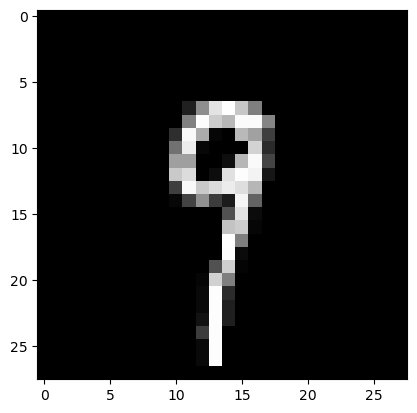

Predicted Label: 5
Actual Label: 8


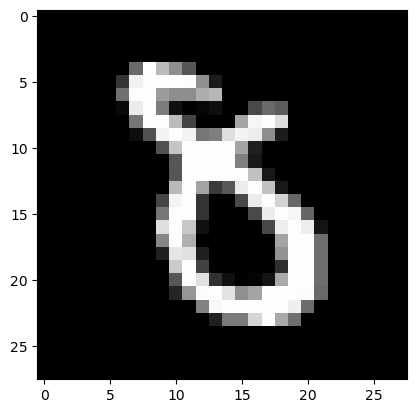

Predicted Label: 7
Actual Label: 9


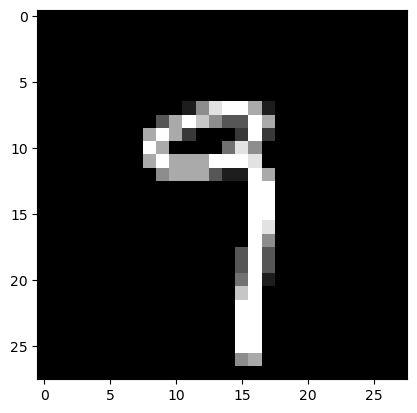

Predicted Label: 3
Actual Label: 2


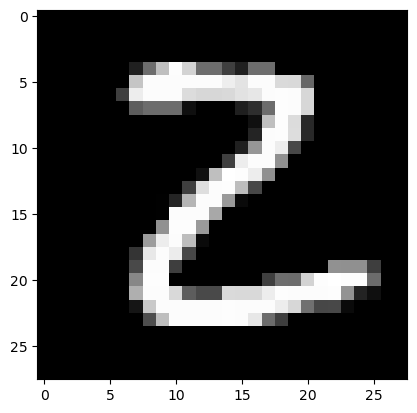

Predicted Label: 6
Actual Label: 4


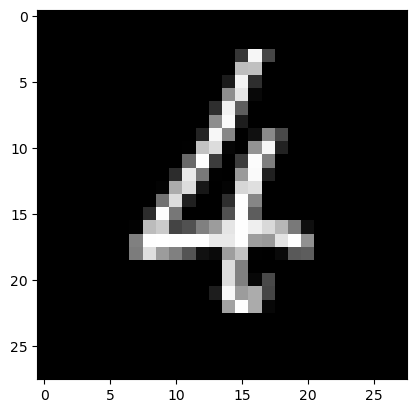

Predicted Label: 8
Actual Label: 2


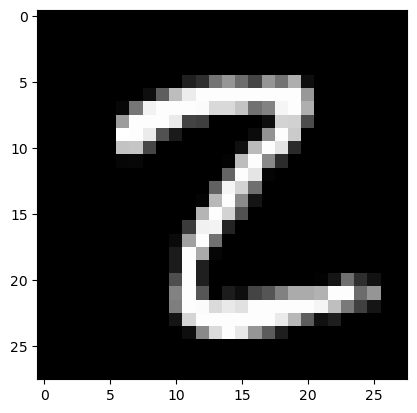

Predicted Label: 5
Actual Label: 1


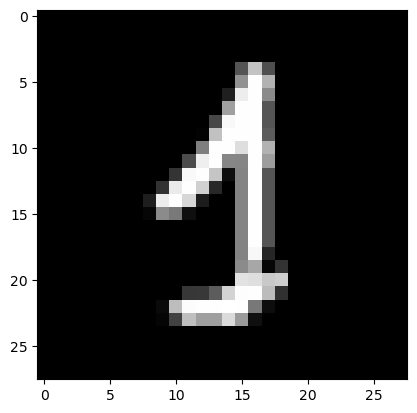

Predicted Label: 3
Actual Label: 5


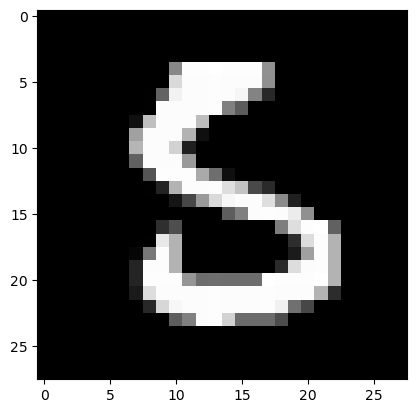

Predicted Label: 3
Actual Label: 5


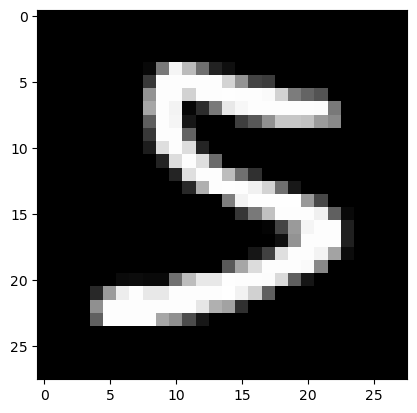

Predicted Label: 9
Actual Label: 4


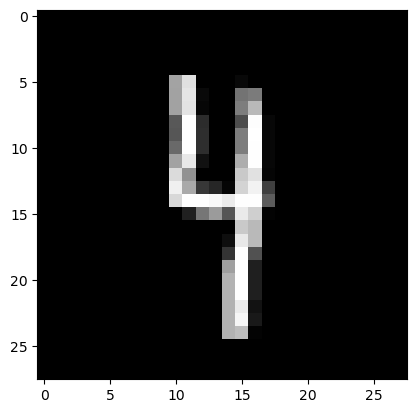

In [26]:
display_wrong_predictions(X_dev, Y_dev, dev_predictions, W1, b1, W2, b2, W3, b3)

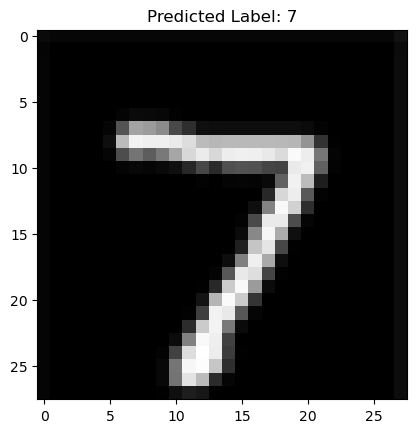

7

In [27]:
image_path = "../data/7_black.png"
predict_image(image_path, W1, b1, W2, b2, W3, b3)